In [1]:
'''
GCBC with point maze (with multi-goal + color state space)
'''
from __future__ import print_function, division, unicode_literals
%load_ext autoreload
%autoreload 2
import math
import time
import os
import copy
import unicodedata
import string
import re
import random
import io
from io import open

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import distributions as pyd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib import cm
%matplotlib inline
import seaborn as sns
from PIL import Image
import cv2
import minigrid

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode - o

from sentence_transformers import SentenceTransformer
lang_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

In [2]:
# Custom weight init for Conv2D and Linear layers
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight.data)
        if hasattr(m.bias, "data"):
            m.bias.data.fill_(0.0)
                
# helper mlp init function
def mlp(input_dim, output_dim, hidden_dim, hidden_depth, output_mod=None):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), nn.ReLU(inplace=True)]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(inplace=True)]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

# MLP policy
class MLPPolicy(nn.Module):
    def __init__(
        self, obs_dim, action_dim, hidden_dim, hidden_depth, output_mod=None
    ):
        super().__init__()
        self.trunk = mlp(input_dim, output_dim, hidden_dim, hidden_depth, output_mod)
        self.outputs = dict()
        self.apply(weight_init)

    def forward(self, x):
        return self.trunk(x)

# MLP policy
class CNNPolicy(nn.Module):
    def __init__(
        self, goal_dim, action_dim, hidden_size, mask=False, output_mod=None):
        super().__init__()
        self.mask = mask
        self.goal = mlp(goal_dim, hidden_size, hidden_dim=0, hidden_depth=0, output_mod=None) # => hidden_size
        self.conv = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=8,stride=4), nn.ReLU(inplace=True), nn.BatchNorm2d(32), #(b_size,3,36,36)=>(b_size,32,8,8)
            nn.Conv2d(32,64,kernel_size=4,stride=2), nn.ReLU(inplace=True), nn.BatchNorm2d(64), #(b_size,32,8,8)=>(b_size,64,3,3)
            nn.Conv2d(64,32,kernel_size=3,stride=1), nn.LeakyReLU(inplace=True), Flatten(), nn.BatchNorm1d(32), #(b_size,64,3,3)=>(b_size,32,1,1)=>(b_size,32*1*1)
            nn.Linear(32*1*1, hidden_size) #(b_size,32*1*1)=>(b_size,hidden_size)
        )
        self.process = mlp(hidden_size*2, 1*36*36, hidden_dim=1000, hidden_depth=1, output_mod=nn.Sigmoid()) #(b_size,hidden_size*2)=>(b_size,32*1*1)
        # UNet deconv mask --------------------------------------------------------------------------------------------------
        #self.deconv = nn.Sequential(
        #    nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1), nn.LeakyReLU(inplace=True), nn.BatchNorm2d(64), #(b_size,32*1*1)=>(b_size,64,3,3)
        #    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2), nn.LeakyReLU(inplace=True), nn.BatchNorm2d(32), #(b_size,64,3,3)=>(b_size,32,8,8)
        #    nn.ConvTranspose2d(32, 1, kernel_size=8, stride=4), nn.Sigmoid(), #(b_size,32,8,8)=>(b_size,3,36,36)
        #)
        self.cnntrunk = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4), nn.ReLU(inplace=True), nn.BatchNorm2d(32), #(b_size,3,36,36)=>(b_size,32,8,8)
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(inplace=True), nn.BatchNorm2d(64), #(b_size,32,8,8)=>(b_size,64,3,3)
            nn.Conv2d(64, 32, kernel_size=3, stride=1), nn.LeakyReLU(inplace=True), nn.BatchNorm2d(32), Flatten(), #(b_size,64,3,3)=>(b_size,32,1,1)=>(b_size,32*1*1)
            nn.Linear(32*1*1, action_dim)#, nn.LeakyReLU(inplace=True), nn.BatchNorm1d(32), #(b_size,32*1*1)=>(b_size,hidden_size)
            #nn.Linear(32, action_dim) #(b_size,hidden_size)=>(b_size,action_dim)
        )
        self.mlptrunk = mlp(hidden_size*2, action_dim, hidden_dim=100, hidden_depth=1) #(b_size,hidden_size*2)=>(b_size,action_dim)
        self.apply(weight_init)

    def forward(self, goal, state, gt_mask):
        state = state/255.0 # process image + switch channels
        state = state.permute(0,3,1,2)
        state_embed = self.conv(state)
        goal_embed = self.goal(goal) # process goal
        goal_state = torch.cat((goal_embed,state_embed),dim=1) # process goal + state
        
        if self.mask:
            img_mask = self.process(goal_state)
            img_mask = img_mask.reshape(-1,1,36,36)
            #img_mask = img_mask.reshape(-1,32,1,1)
            #img_mask = self.deconv(img_mask) # deconv for mask
            #--------------------- test with gt mask
            #img_mask = gt_mask.reshape((-1, 36, 36, 1)) # reshape to 1 channel
            #img_mask = np.repeat(img_mask, 3, axis=3) # duplicate across 3 channels
            #img_mask = img_mask.permute(0,3,1,2) # process channel switch
            #---------------------
            masked_state = state * img_mask # apply mask to full state
            pred = self.cnntrunk(masked_state)
            return [pred, masked_state, img_mask]
        else:
            pred = self.mlptrunk(goal_state)
            return [pred]

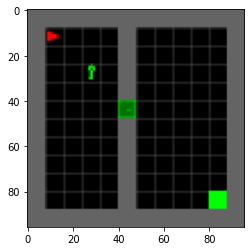

In [3]:
import gym
from minigrid.wrappers import RGBImgObsWrapper, ImgObsWrapper
env = gym.make('MiniGrid-DoorKeySpecial')
env = RGBImgObsWrapper(env) # Get pixel observations
env = ImgObsWrapper(env) # Get rid of the 'mission' field
obs = env.reset()[0] # This now produces an RGB tensor only
plt.imshow(obs)

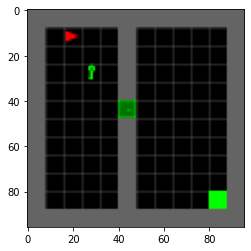

In [4]:
obs = env.step(2)[0]
plt.imshow(obs)

In [5]:
# generates random trajs within specified constraints
env = gym.make('MiniGrid-DoorKeySpecial')
env = RGBImgObsWrapper(env) # Get pixel observations
env = ImgObsWrapper(env) # Get rid of the 'mission' field

def gen_trajs(env, num_trajs=1, key_location=[0,1], door_location=[0,1], colors=[0,1], scalar=5):
    trajs = []
    for traj in range(num_trajs):
        #env.reset(agent_pos=agent_pos, obj_pos=obj_pos, obj_colors=obj_colors, obj_shapes=obj_shapes, scalar=scalar)
        obs = env.reset()[0] # This now produces an RGB tensor only
        # rolls out a trajectory towards the goal
        traj = {'obs': [],'acts': [],'goal': []}
        goal = [1,0,0]
        
        # go to key
        for i in range(env.key-1):
            act = 2
            traj['obs'].append(obs.copy())
            traj['acts'].append(act.copy())
            traj['goal'].append(goal)
            no = env.step(act)[0]
            obs = no.copy()
        # pick up key
        traj['obs'].append(obs.copy())
        traj['acts'].append(act.copy())
        traj['goal'].append(goal)
        no = env.step(3)[0]
        obs = no.copy()
        # go to door
        for i in range(env.door):
            act = 2
            traj['obs'].append(obs.copy())
            traj['acts'].append(act.copy())
            traj['goal'].append(goal)
            no = env.step(act)[0]
            obs = no.copy()
        # go to goal
        traj['obs'] = np.array(traj['obs'])
        traj['acts'] = np.array(traj['acts'])
        traj['goal'] = np.array(traj['goal'])
        traj['gt_masks'] = np.array(traj['gt_masks'])
        #plt.plot(traj['obs'][:, 0], traj['obs'][:, 1]) # plots trajs + goals
        trajs.append(traj)
    return trajs